 ## 3D data processing

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import open3d as o3d

import os
import numpy as np
import math

from sklearn.cluster import DBSCAN

In [6]:
# for deployment
from star_solution.utils import filter_points,largest_cluster_outliers, ransac_plane_outliers, project_points_to_plane, pattern_match, compare_clouds_by_centroid

In [7]:
# for dev only
from star_solution.utils import load_all_dumps_with_pose, plot_intensity_hist, visualize_inline, visualize_cloud, visualize_plane_with_points

In [8]:
# # Загружаем все дампы
# files, clouds = load_all_dumps()

# # Смотрим список файлов
# for i, f in enumerate(files):
#     print(i, f, clouds[i].shape)

# Загружаем все дампы
files, clouds_and_poses = load_all_dumps_with_pose()

# Смотрим список файлов
clouds = []
poses = []
for fname, (cloud, pose) in zip(files, clouds_and_poses):
    print(f"{fname}: {cloud.shape[0]} точек, pose = {pose}")
    clouds.append(cloud)    
    poses.append(pose)
    



/home/likerobotics/lidar_filtered_dumps/filtered_1756549169.npy: 7612 точек, pose = [0. 0. 0.]
/home/likerobotics/lidar_filtered_dumps/filtered_1756549172.npy: 7450 точек, pose = [-0.005508   0.0054696 -1.5693438]
/home/likerobotics/lidar_filtered_dumps/filtered_1756549175.npy: 7579 точек, pose = [0. 0. 0.]
/home/likerobotics/lidar_filtered_dumps/filtered_1756549178.npy: 7664 точек, pose = [0. 0. 0.]
/home/likerobotics/lidar_filtered_dumps/filtered_1756549181.npy: 7551 точек, pose = [-5.7389666e-03 -3.4533886e-04 -1.5716535e+00]
/home/likerobotics/lidar_filtered_dumps/filtered_1756549184.npy: 7573 точек, pose = [ 1.0359057e-02  1.5138991e-03 -1.5691990e+00]
/home/likerobotics/lidar_filtered_dumps/filtered_1756549187.npy: 7718 точек, pose = [0. 0. 0.]
/home/likerobotics/lidar_filtered_dumps/filtered_1756549190.npy: 7538 точек, pose = [ 0.00268392 -0.00223368 -1.5687442 ]
/home/likerobotics/lidar_filtered_dumps/filtered_1756549193.npy: 7522 точек, pose = [-8.4915402e-04 -9.3487240e-02 -1

## Гистограмма интенсивности

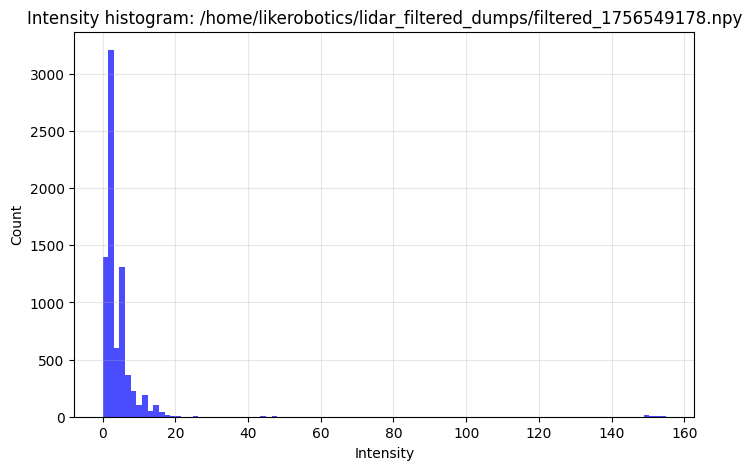

In [9]:

i = 3

points = clouds[i]

# Строим гистограмму интенсивности
plot_intensity_hist(points, bins=100, title=f"Intensity histogram: {files[i]}")

## Визуализация

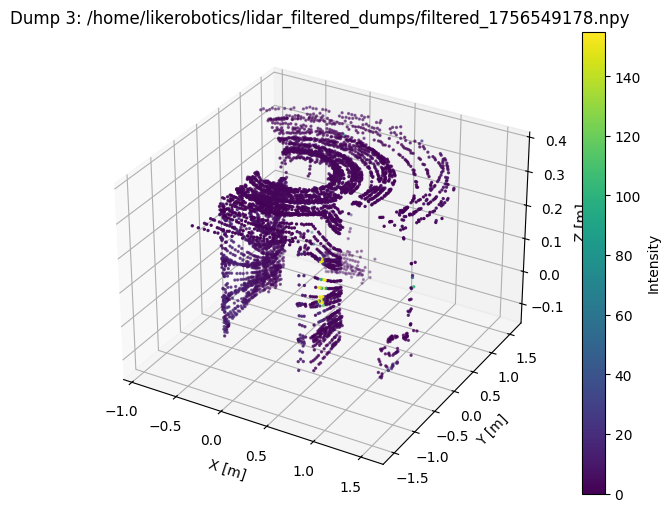

In [11]:

visualize_inline(clouds[i], title=f"Dump {i}: {files[i]}")

# Фильрация по инетсивности

In [12]:
filtered = filter_points(points,
                         intensity_min=60, intensity_max=205,
                         range_min=0.2, range_max=2.0,
                         z_min=-0.5, z_max=0.5)

print(f"Исходных точек: {points.shape[0]}, после фильтра: {filtered.shape[0]}")

Исходных точек: 7664, после фильтра: 39


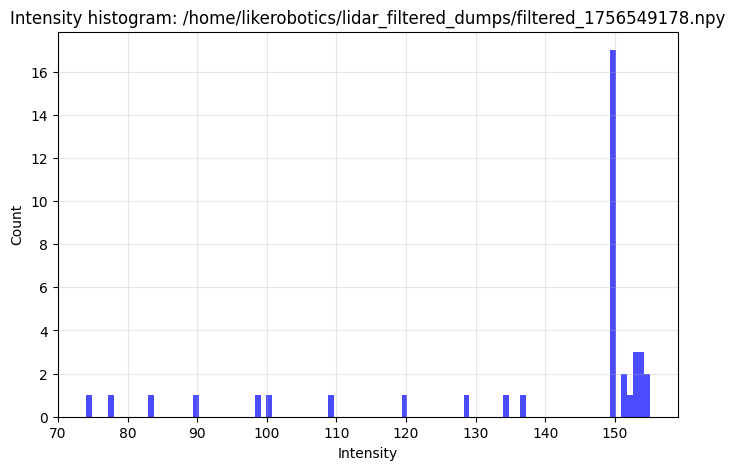

In [13]:
plot_intensity_hist(filtered, bins=100, title=f"Intensity histogram: {files[i]}")

In [14]:
visualize_cloud(filtered, title="filtered")

## Кластеризация

In [15]:
# Кластеризация
labels, main_cluster, outliers = largest_cluster_outliers(filtered, eps=0.1, min_samples=20)

print(f"Главный кластер: {main_cluster.shape[0]} точек")
print(f"Выбросы: {outliers.shape[0]} точек")

# Визуализируем
visualize_cloud(main_cluster, title="Main Cluster (DBSCAN)")

Главный кластер: 36 точек
Выбросы: 3 точек


# Запускаем RANSAC

In [16]:

plane_model, inliers, outliers = ransac_plane_outliers(main_cluster, distance_threshold=0.025)

print("Найденная плоскость: ax+by+cz+d=0")
print(plane_model)
print(f"На плоскости: {inliers.shape[0]} точек")
print(f"Выбросы: {outliers.shape[0]} точек")

# Визуализируем выбросы
visualize_cloud(outliers, title="Outliers (не на плоскости)")

Найденная плоскость: ax+by+cz+d=0
[ 0.99846961 -0.05434393  0.01025586 -0.63621459]
На плоскости: 36 точек
Выбросы: 0 точек
Файл пустой или нет точек


In [17]:
inliers.shape

(36, 4)

In [18]:
visualize_plane_with_points(plane_model, inliers, outliers)

## Переход в 2D

In [19]:
proj3d, proj2d, basis = project_points_to_plane(inliers, plane_model)
print("Проекция 3D shape:", proj3d.shape)  # (N,3)
print("Проекция 2D shape:", proj2d.shape)  # (N,2)

Проекция 3D shape: (36, 3)
Проекция 2D shape: (36, 2)


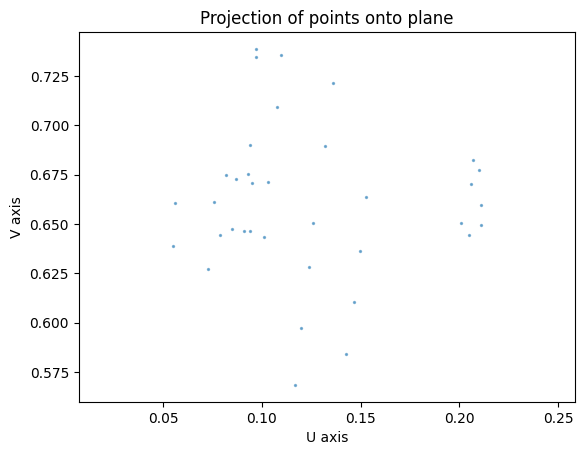

In [20]:
# Нарисуем все точки в 2D координатах
import matplotlib.pyplot as plt
plt.scatter(proj2d[:,0], proj2d[:,1], s=2, alpha=0.5)
plt.xlabel("U axis")
plt.ylabel("V axis")
plt.title("Projection of points onto plane")
plt.axis("equal")
plt.show()

In [21]:
matched_points, percent, L_METRIC = pattern_match(proj2d, d_a=0.01) # 10 mm допустимое отклонение от паттерна размером 150 mm 
print(f"Процент точек в паттерне: {percent:.1f}% {L_METRIC}")

Процент точек в паттерне: 100.0% 0.056731565494769355


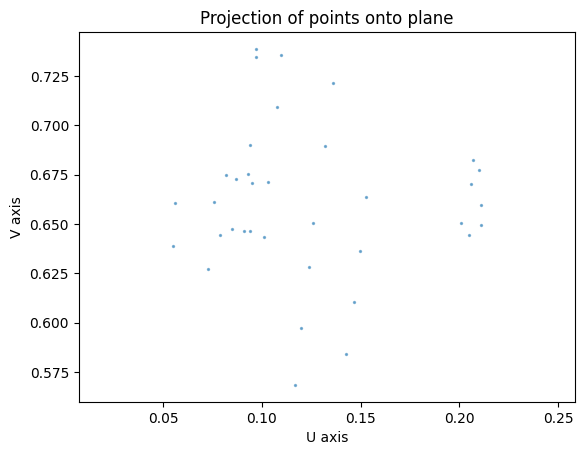

In [22]:
# Нарисуем все точки в 2D координатах

plt.scatter(matched_points[:,0], matched_points[:,1], s=2, alpha=0.5)
plt.xlabel("U axis")
plt.ylabel("V axis")
plt.title("Projection of points onto plane")
plt.axis("equal")
plt.show()

## Полный пайп

(36, 4)
=== Уникальная позиция! ===
robot pose[x,y,thetha]=[0. 0. 0.], FIRST MARKER
(36, 4)
(41, 4)
(36, 4)
(34, 4)
(41, 4)
(35, 4)
(37, 4)
(24, 4)
=== Уникальная позиция! ===
robot pose[x,y,thetha]=[ 8.1624775 -7.1709533  1.6352483], distance to previous marker = 11.665541648864746


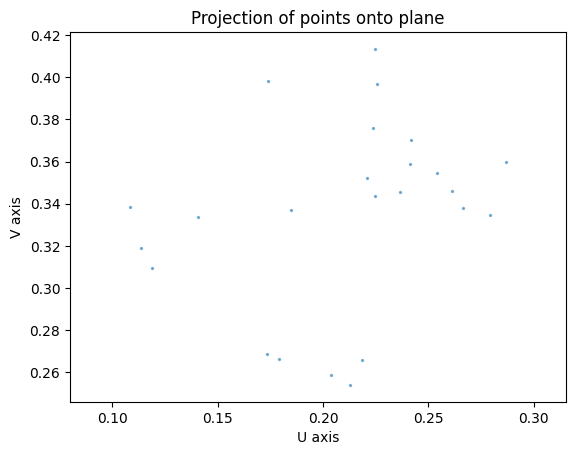

(39, 4)
(35, 4)
=== Уникальная позиция! ===
robot pose[x,y,thetha]=[ 6.308372  -1.7361586 -2.9295352], distance to previous marker = 7.36005973815918


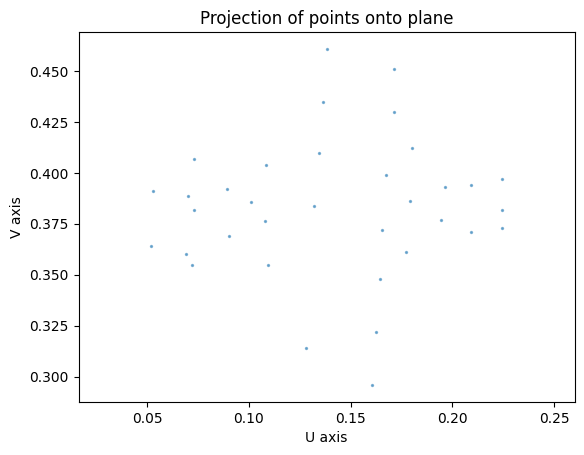

(33, 4)
=== Уникальная позиция! ===
robot pose[x,y,thetha]=[ 0.20043276 -0.794744   -2.9562387 ], distance to previous marker = 6.414356231689453


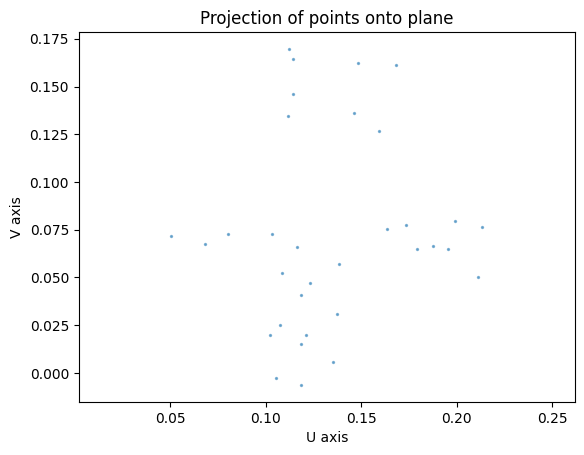

(46, 4)
(42, 4)
(44, 4)
(37, 4)


In [ ]:
uniques_marker_id_list = []
# uniques_marker_robot_pose_list = []
uniques_marker_centers = []


inlier_points_selected = []
metrics_selected = []
poses_selected = []

for ix, points in enumerate(clouds):
    filtered = filter_points(points, intensity_min=60, intensity_max=205, range_min=0.2, range_max=2.0,
                             z_min=-0.5, z_max=0.5)
    if filtered.shape[0] < 30:
        # print("Мало точек после фильтра, пропускаем")
        continue

    labels, main_cluster, outliers = largest_cluster_outliers(filtered, eps=0.3, min_samples=20)
    if main_cluster.shape[0] < 20:
        # print("Мало точек в главном кластере, пропускаем")
        continue

    plane_model, inliers, outliers = ransac_plane_outliers(main_cluster, distance_threshold=0.025)
    if inliers.shape[0] < 10:
        # print("Мало точек на плоскости, пропускаем")
        continue

    proj3d, proj2d, basis = project_points_to_plane(inliers, plane_model)
    matched_points, percent, L_METRIC  = pattern_match(proj2d, d_a=0.01)
    # print(f"Процент точек в паттерне: {percent:.1f}%")

    if percent > 50.0 and (L_METRIC < 0.06 and L_METRIC > 0.04):
        # print(f"Frame {ix} Процент точек в паттерне: {percent:.1f}% L_METRIC={L_METRIC}")
        print(inliers.shape)
        inlier_points_selected.append(inliers)
        metrics_selected.append(L_METRIC)
        poses_selected.append(poses[ix])    

        if len(uniques_marker_id_list) == 0:
            points_A = inlier_points_selected[-1]
            pose_A = poses_selected[-1]
            
            # just fill any numbers to use same function for first and rest cases 
            points_B = inlier_points_selected[-1] 
            pose_B = poses_selected[-1]

            centroid_A, centroid_B, dist_xy, dist_xyz = compare_clouds_by_centroid(points_A, pose_A, points_B, pose_B)
            uniques_marker_id_list.append(ix)
            uniques_marker_centers.append(centroid_A)
            print("=== Уникальная позиция! ===")
            print(f'robot pose[x,y,thetha]={pose_A}, FIRST MARKER')
            
        else:
            points_A = inlier_points_selected[-2]
            pose_A = poses_selected[-2]

            points_B = inlier_points_selected[-1] 
            pose_B = poses_selected[-1]
            centroid_A, centroid_B, dist_xy, dist_xyz = compare_clouds_by_centroid(points_A, pose_A, points_B, pose_B)
            if dist_xy > 1.5:
                uniques_marker_id_list.append(ix)
                uniques_marker_centers.append(centroid_B)
                print("=== Уникальная позиция! ===")
                print(f'robot pose[x,y,thetha]={pose_B}, distance to previous marker = {dist_xy}')

                
                plt.scatter(matched_points[:,0], matched_points[:,1], s=2, alpha=0.5)
                plt.xlabel("U axis")
                plt.ylabel("V axis")
                plt.title("Projection of points onto plane")
                plt.axis("equal")
                plt.show()